In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.integrate import odeint, ode, solve_ivp
import seaborn as sns
from copy import deepcopy
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from scipy import interpolate
from scipy.interpolate import CubicSpline
import warnings
warnings.filterwarnings("ignore")
%run -i '../../../../../utils.py'

In [44]:
def get_observed_vs_predicted_scfa_dynamics(intrapolation=True, feedback=False, solver_method='BDF'):
    df_pred = None
    if intrapolation:
        exclude_set = ['A','B','C','D']
        fig, ax = plt.subplots(figsize=(20,12), nrows=4, ncols=4, sharex=True)
    else:
        exclude_set = ['Beijing','Guangdong','Hunan','Shanghai']
        fig, ax = plt.subplots(figsize=(24,12), nrows=4, ncols=5, sharex=True)
    scfa_color={'Acetate':'#DB5E56', 'Butyrate':'#56DB5E', 'Propionate':'#5E56DB'}
    for idx_i,to_exclude in enumerate(exclude_set):

        # get raw data
        df_meta_raw = pd.read_excel('../../../../../our_data/meta_data.xlsx', index_col=0)
        df_meta_raw = df_meta_raw[df_meta_raw.Diet=='Inulin']
        df_meta_raw = df_meta_raw.drop('Diet', axis=1)
        df_scfa_raw = pd.read_excel('../../../../../our_data/SCFA.xlsx', index_col=0)
        df_bac_raw = pd.read_excel('../../../../../our_data/16S_absolute_abundance.xlsx', index_col=0)

        # get SCFA derivative for all mice
        target_scfa_raw=['Acetate','Butyrate','Propionate']
        target_scfa, df_meta_raw, df_bac_raw, df_scfa_raw, df_scfa_deriv_raw = data_processing_scfa(df_meta_raw, df_bac_raw, df_scfa_raw, target_scfa=target_scfa_raw, topN=40, normalize_X=True, exclude_group=None, exclude_vendor=None, use_deriv=False)
        df_scfa_deriv_raw = df_scfa_deriv_raw[target_scfa]
        df_scfa_deriv_raw.columns = [x+'_deriv_observed' for x in target_scfa]

        # get trained model
        if intrapolation:
            if feedback:
                df_opt_paras = pd.read_csv('intrapolation/optimal_rf_parameters_w_feedback_exclude_group%s.csv'%(to_exclude), index_col=0)
            else:
                df_opt_paras = pd.read_csv('intrapolation/optimal_rf_parameters_no_feedback_exclude_group%s.csv'%(to_exclude), index_col=0)
            _,_,reg = train_scfa_dynamics_model(
                df_meta=df_meta_raw, # meta data
                df_bac=df_bac_raw,  # relative abundace or absolute abundance of gut microbiome
                df_scfa=df_scfa_raw, # SCFA measurement
                target_scfa=target_scfa, # dependent variable(s) in the regression
                topN=40, # keep only the most abundance N taxa in the model
                normalize_X=True, # normalize maximum of bacterial abundance to 1
                exclude_group=to_exclude, # group of mice excluded from model training
                exclude_vendor=None, # group of mice excluded from model training
                model='RandomForest',# regression model
                opt_params = df_opt_paras, # optimal model parameters
                feedback=feedback, # if True, add SCFA feedback, i.e., dSCFA/dt = f(microbiome, SCFA)
                use_deriv=False # use scfa derivative as dependent variables
            )
        else:
            if feedback:
                df_opt_paras = pd.read_csv('extrapolation/optimal_rf_parameters_w_feedback_exclude_vendor%s.csv'%(to_exclude), index_col=0)
            else:
                df_opt_paras = pd.read_csv('extrapolation/optimal_rf_parameters_no_feedback_exclude_vendor%s.csv'%(to_exclude), index_col=0)
            _,_,reg = train_scfa_dynamics_model(
                df_meta=df_meta_raw, # meta data
                df_bac=df_bac_raw,  # relative abundace or absolute abundance of gut microbiome
                df_scfa=df_scfa_raw, # SCFA measurement
                target_scfa=target_scfa, # dependent variable(s) in the regression
                topN=40, # keep only the most abundance N taxa in the model
                normalize_X=True, # normalize maximum of bacterial abundance to 1
                exclude_group=None, # group of mice excluded from model training
                exclude_vendor=to_exclude, # group of mice excluded from model training
                model='RandomForest',# regression model
                opt_params = df_opt_paras, # optimal model parameters
                feedback=feedback, # if True, add SCFA feedback, i.e., dSCFA/dt = f(microbiome, SCFA)
                use_deriv=False # use scfa derivative as dependent variables
            )

        # make sure different tables have consistent samples
        if intrapolation:
            df_meta_2pred = df_meta_raw[df_meta_raw.RandomizedGroup==to_exclude]
        else:
            df_meta_2pred = df_meta_raw[df_meta_raw.Vendor==to_exclude]
        df_meta_scfa_2pred = pd.merge(df_meta_2pred, df_scfa_raw, left_index=True, right_index=True, how='inner')
        df_meta_scfa_2pred = pd.merge(df_meta_scfa_2pred, df_scfa_deriv_raw, left_index=True, right_index=True, how='inner')
        df_meta_scfa_bac_2pred = pd.merge(df_meta_scfa_2pred, df_bac_raw, left_index=True, right_index=True, how='inner')

        # get derivative of SCFA
        for scfa_ in target_scfa:
            # get regression results
            topN_taxa = reg[scfa_].feature_names
            if feedback:
                assert topN_taxa[-1] == 'SCFA_fdb'
                topN_taxa = topN_taxa[0:-1] # remove last feature 'SCFA_fdb'

            if feedback:
                X_var = np.concatenate((np.asarray(df_meta_scfa_bac_2pred[topN_taxa].values), np.asarray(df_meta_scfa_bac_2pred[scfa_]).reshape(-1,1)), 1)
            else:
                X_var = np.asarray(df_meta_scfa_bac_2pred[topN_taxa].values)
            curr_pred = reg[scfa_].predict(X_var)
            curr_pred = [x if x>0 else 0 for x in curr_pred]
            df_meta_scfa_bac_2pred['%s_deriv_predicted'%(scfa_)] = curr_pred

        # predict SCFA value
        all_mice = set(df_meta_scfa_bac_2pred['MiceID'])
        for scfa_ in target_scfa:

            # get regression results
            topN_taxa = reg[scfa_].feature_names
            if feedback:
                assert topN_taxa[-1] == 'SCFA_fdb'
                topN_taxa = topN_taxa[0:-1] # remove last feature 'SCFA_fdb'

            # get predicted SCFA for each mouse
            for idx_j, curr_mice in enumerate(all_mice):
                df_tmp = df_meta_scfa_bac_2pred[(df_meta_scfa_bac_2pred.MiceID==curr_mice)].sort_values(by='Day')
                df_tmp = df_tmp[['MiceID','Vendor','Day','RandomizedGroup',scfa_,scfa_+'_deriv_observed',scfa_+'_deriv_predicted']]
                df_tmp = df_tmp.rename({scfa_:'SCFA_value_observed',
                                        scfa_+'_deriv_observed':'SCFA_deriv_observed',
                                        scfa_+'_deriv_predicted':'SCFA_deriv_predicted'
                                       }, axis=1)
                df_tmp['SCFA_mol'] = scfa_
                if df_pred is None:
                    df_pred = df_tmp
                else:
                    df_pred = pd.concat([df_pred, df_tmp], ignore_index=True)

                # interpolate the values to a much finer x-avis coordinates
                _ = ax[idx_i,idx_j].scatter(df_tmp.Day, df_tmp.SCFA_deriv_observed, marker='o', color=scfa_color[scfa_], s=100, label=scfa_)
                _ = ax[idx_i,idx_j].plot(df_tmp.Day, df_tmp.SCFA_deriv_predicted, '-', marker="s", markersize=10, color=scfa_color[scfa_])
                _ = ax[idx_i,idx_j].set_title(curr_mice)
                if idx_i==0 and idx_j==0:
                    ax[idx_i,idx_j].legend()
                ax[idx_i,idx_j].set_xlim([-3.2,32])
                if idx_j==0:
                    ax[idx_i,idx_j].set_ylabel('SCFA', fontsize=15)
                if idx_i==3:
                    ax[idx_i,idx_j].set_xlabel('Day', fontsize=15)

    plt.tight_layout()
    plt.rcParams['svg.fonttype'] = 'none'
    if intrapolation:
        if feedback:
            fig.savefig("prediction_intrapolation_w_feedback.svg", format="svg")
        else:
            fig.savefig("prediction_extrapolation_no_feedback.svg", format="svg")
    else:
        if feedback:
            fig.savefig("prediction_intrapolation_w_feedback.svg", format="svg")
        else:
            fig.savefig("prediction_extrapolation_no_feedback.svg", format="svg")

    return df_pred

# Intrapolation, no feedback

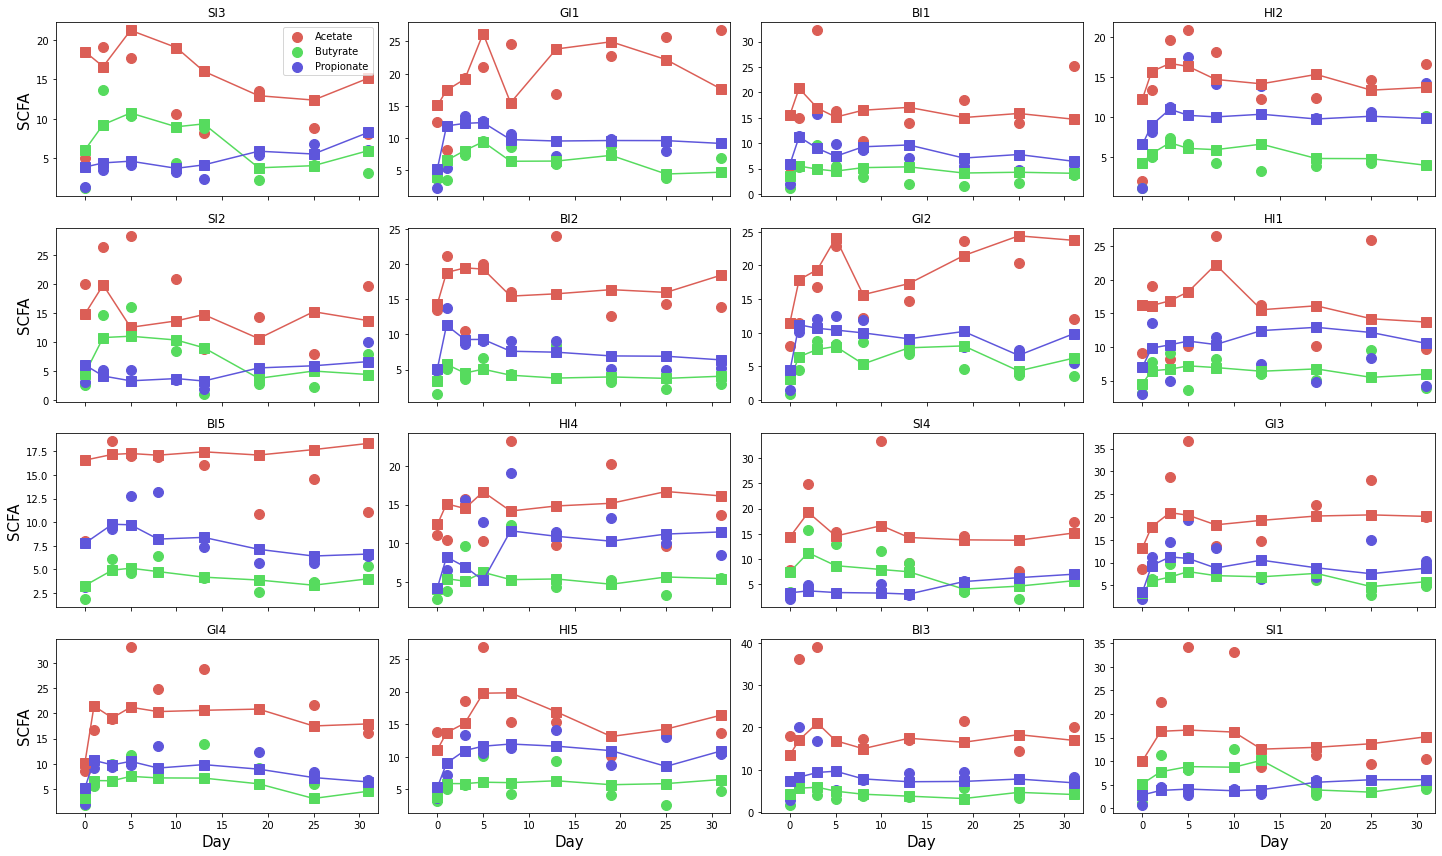

In [45]:
df_intra_no_feedback = get_observed_vs_predicted_scfa_dynamics(intrapolation=True, feedback=False, solver_method='RK45')
df_intra_no_feedback.to_csv('prediction_intrapolation_no_feedback.csv')

# Intrapolation, w/ feedback

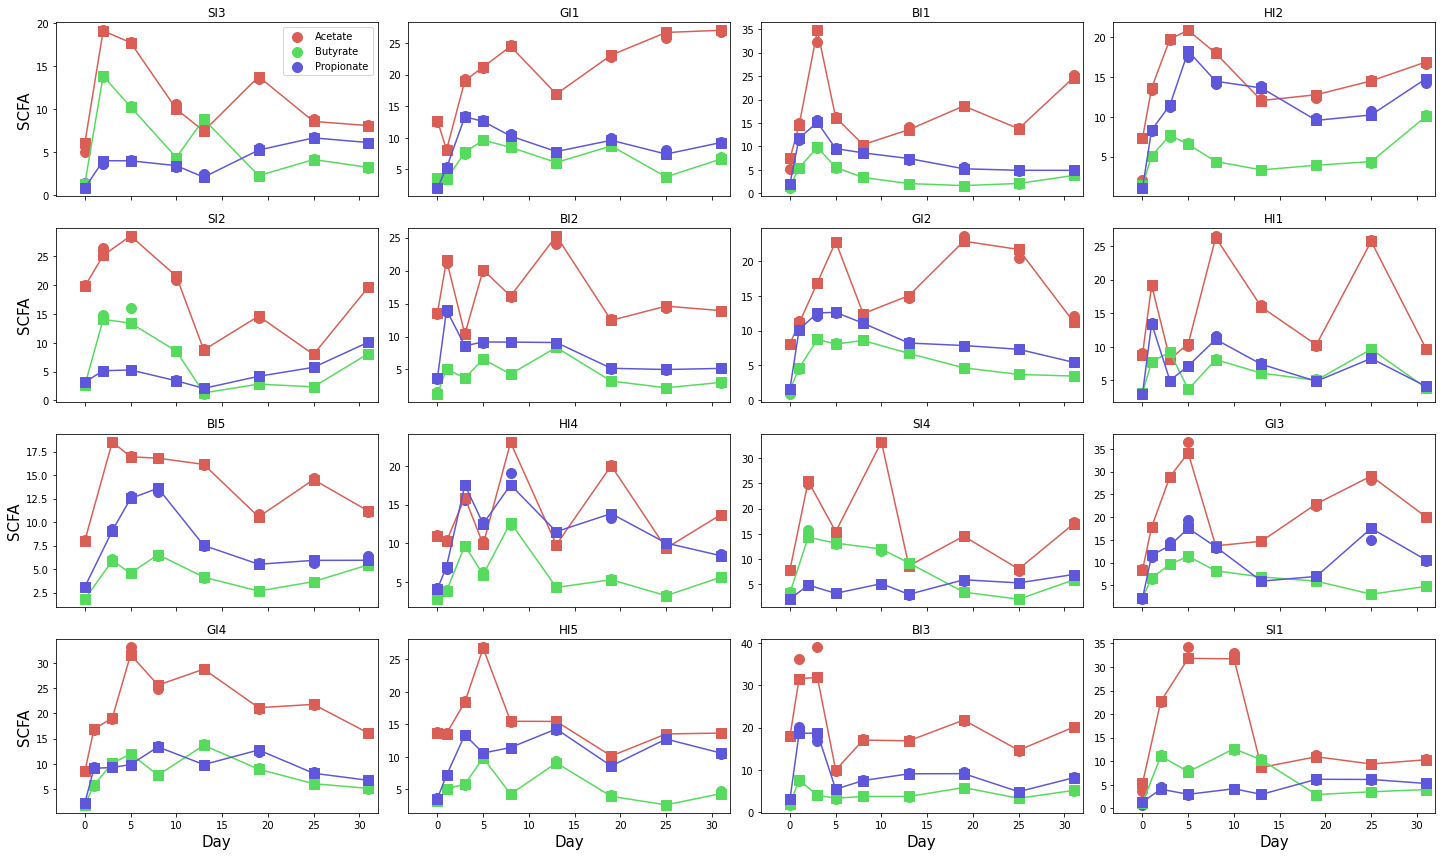

In [46]:
df_intra_w_feedback = get_observed_vs_predicted_scfa_dynamics(intrapolation=True, feedback=True, solver_method='RK45')
df_intra_w_feedback.to_csv('prediction_intrapolation_w_feedback.csv')

# Extrapolation, no feedback

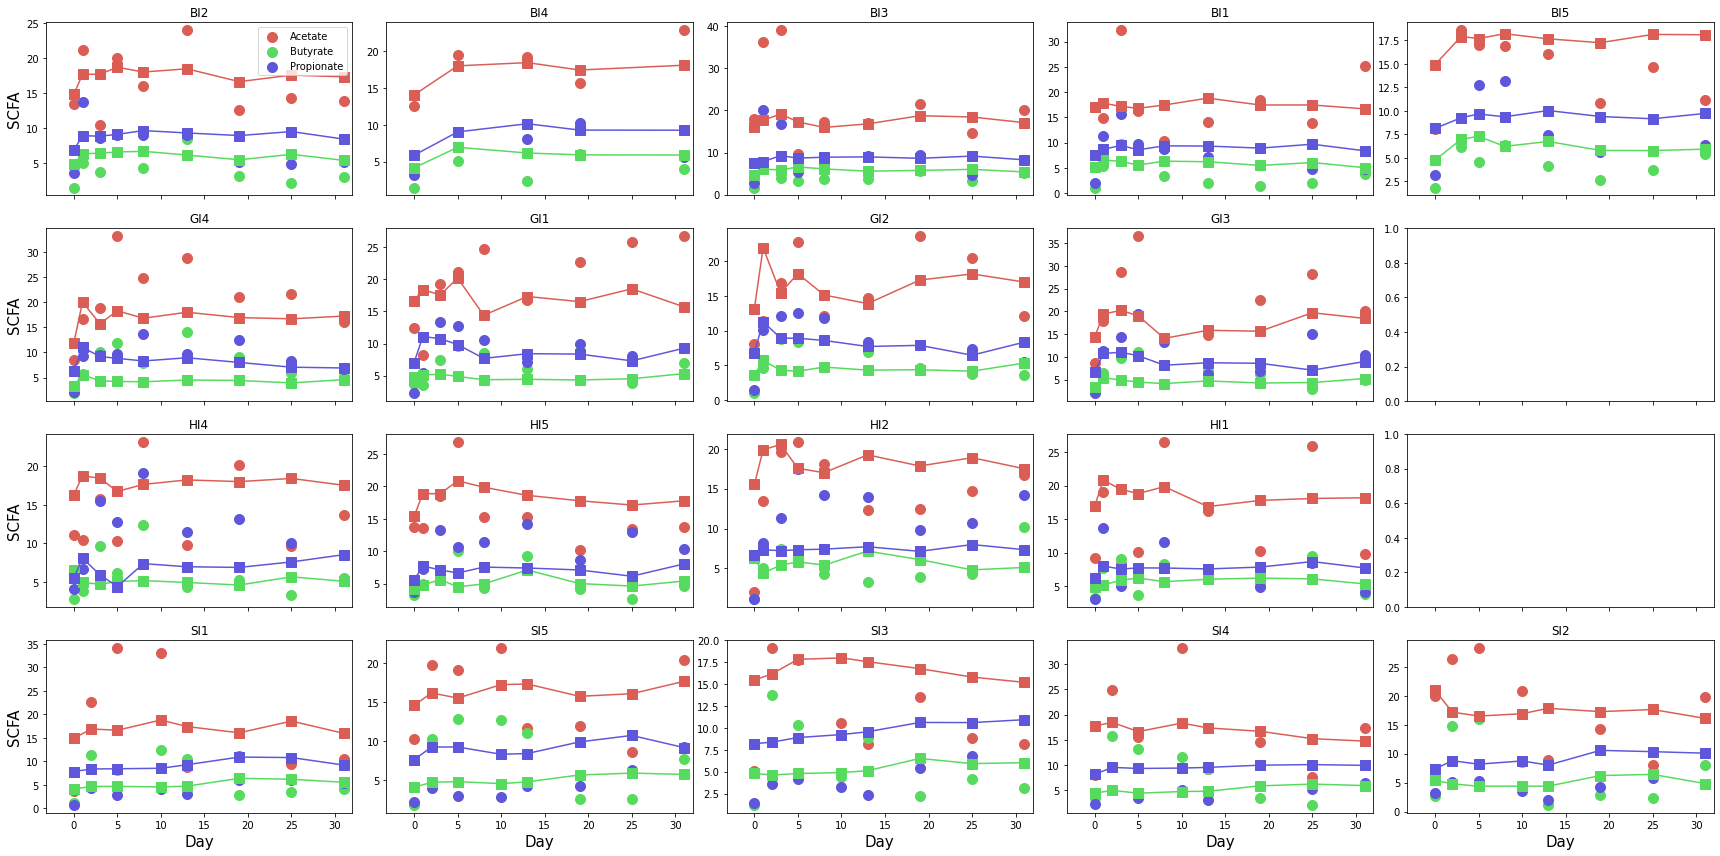

In [47]:
df_extra_no_feedback = get_observed_vs_predicted_scfa_dynamics(intrapolation=False, feedback=False, solver_method='RK45')
df_extra_no_feedback.to_csv('prediction_extrapolation_no_feedback.csv')

# Extrapolation, w/ feedback

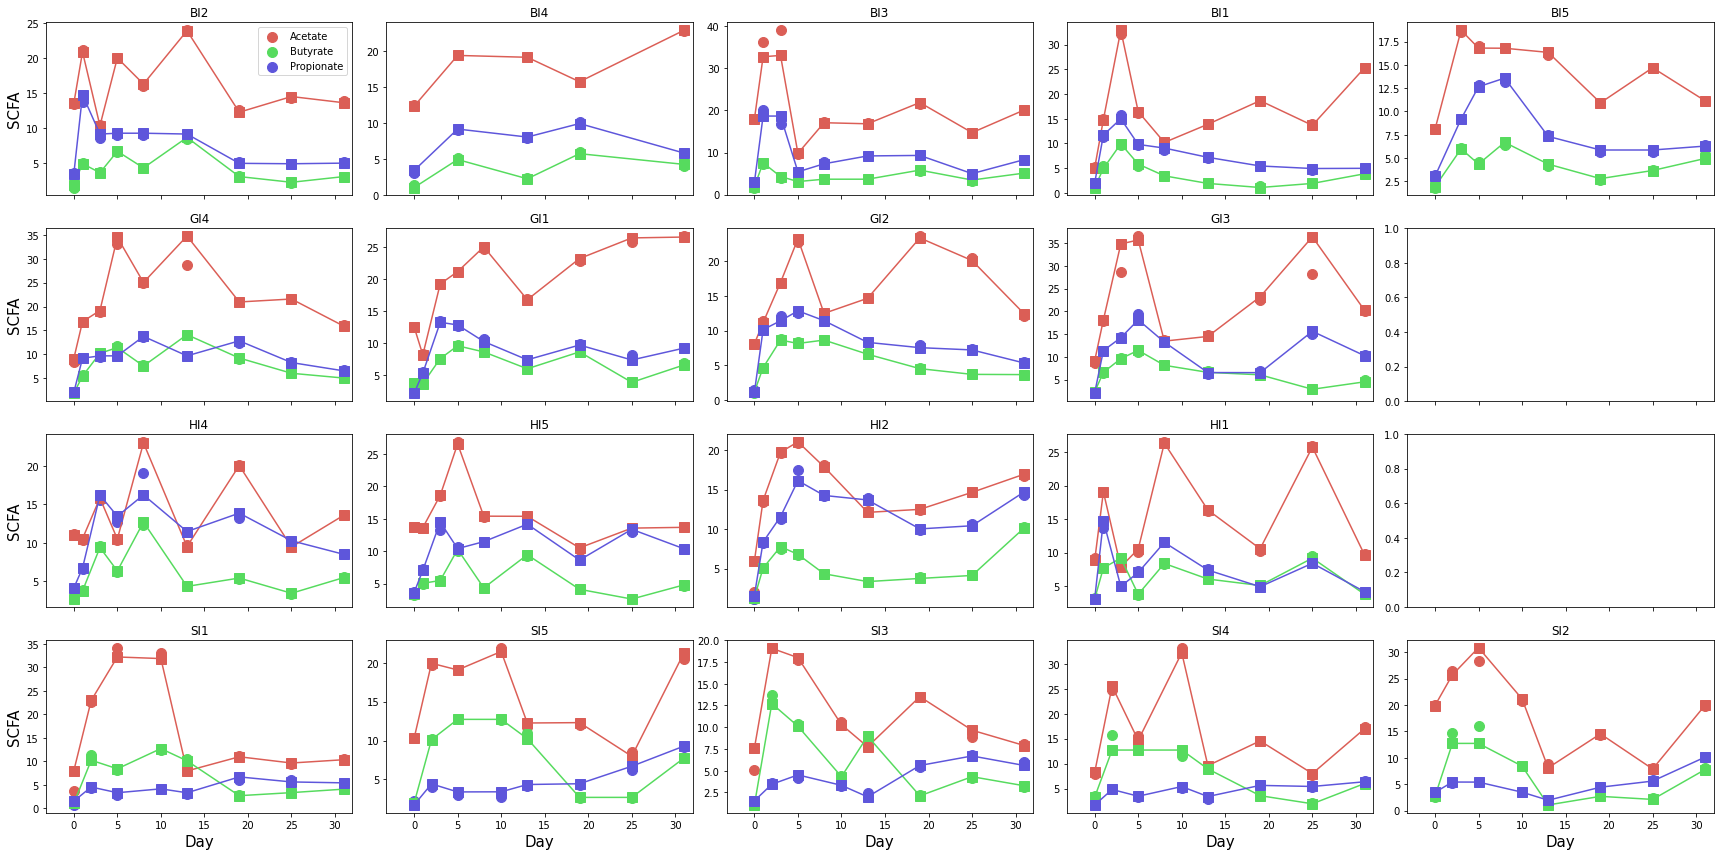

In [48]:
df_extra_w_feedback = get_observed_vs_predicted_scfa_dynamics(intrapolation=False, feedback=True, solver_method='RK45')
df_extra_w_feedback.to_csv('prediction_extrapolation_w_feedback.csv')

# Plot time-dependent prediction error

In [50]:
df_intra_no_feedback = pd.read_csv('prediction_intrapolation_no_feedback.csv', index_col=0)
df_intra_no_feedback['Perturbation'] = 'intrapolation'
df_intra_no_feedback['Feedback'] = False
df_intra_w_feedback = pd.read_csv('prediction_intrapolation_w_feedback.csv', index_col=0)
df_intra_w_feedback['Perturbation'] = 'intrapolation'
df_intra_w_feedback['Feedback'] = True
df_extra_no_feedback = pd.read_csv('prediction_extrapolation_no_feedback.csv', index_col=0)
df_extra_no_feedback['Perturbation'] = 'extrapolation'
df_extra_no_feedback['Feedback'] = False
df_extra_w_feedback = pd.read_csv('prediction_extrapolation_w_feedback.csv', index_col=0)
df_extra_w_feedback['Perturbation'] = 'extrapolation'
df_extra_w_feedback['Feedback'] = True
df_test = pd.concat([df_intra_no_feedback,df_intra_w_feedback,df_extra_no_feedback,df_extra_w_feedback], ignore_index=True)
df_test['SCFA_deriv_abserror'] = df_test['SCFA_deriv_predicted']-df_test['SCFA_deriv_observed']
df_test['SCFA_deriv_relerror'] = (df_test['SCFA_deriv_predicted']-df_test['SCFA_deriv_observed'])/df_test['SCFA_deriv_observed']*100
df_test.to_csv('time_dependent_relerror.csv')
df_test.head()

,MiceID,Vendor,Day,RandomizedGroup,SCFA_value_observed,SCFA_deriv_observed,SCFA_deriv_predicted,SCFA_mol,Perturbation,Feedback,SCFA_deriv_abserror,SCFA_deriv_relerror
0,SI3,Shanghai,0,A,5.055757,5.055757,18.518185,Acetate,intrapolation,False,13.462429,266.279213
1,SI3,Shanghai,2,A,19.149833,19.149833,16.626618,Acetate,intrapolation,False,-2.523215,-13.176172
2,SI3,Shanghai,5,A,17.736701,17.736701,21.223508,Acetate,intrapolation,False,3.486807,19.658711
3,SI3,Shanghai,10,A,10.600160,10.600160,19.038405,Acetate,intrapolation,False,8.438245,79.604881
4,SI3,Shanghai,13,A,8.158938,8.158938,16.029440,Acetate,intrapolation,False,7.870502,96.464793


## SCFA value error

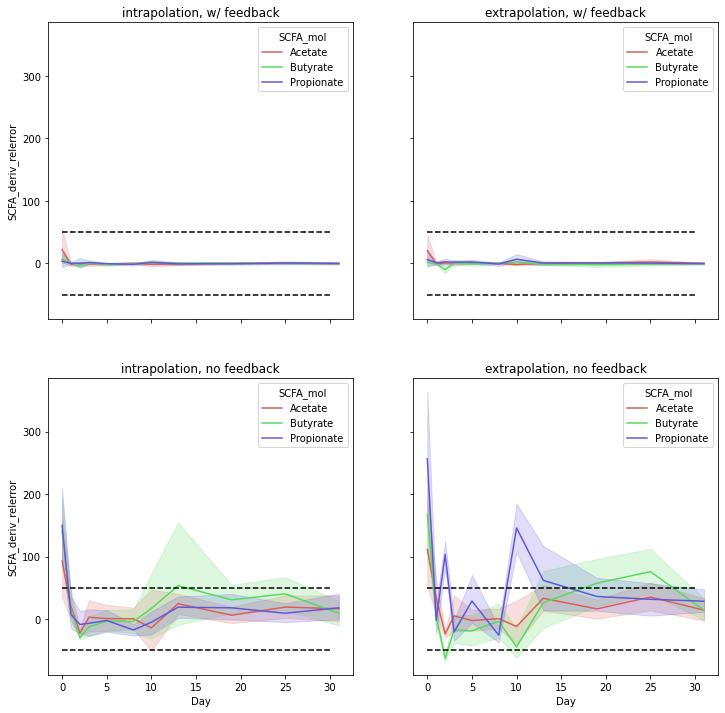

In [42]:
fig, ax = plt.subplots(figsize=(12,12), nrows=2, ncols=2, sharex=True, sharey=True)
for idx_i,feedback in enumerate([True, False]):
    for idx_j, perturbation in enumerate(['intrapolation','extrapolation']):
        _ = sns.lineplot(x='Day', y='SCFA_deriv_relerror', hue='SCFA_mol', data=df_test[(df_test.Perturbation==perturbation)&(df_test.Feedback==feedback)], ax=ax[idx_i,idx_j], palette=sns.color_palette("hls", 3))
        if feedback:
            _=ax[idx_i,idx_j].set_title('%s, w/ feedback'%(perturbation))
        else:
            _=ax[idx_i,idx_j].set_title('%s, no feedback'%(perturbation))
        _ = ax[idx_i,idx_j].plot([0,30],[50,50],'k--')
        _ = ax[idx_i,idx_j].plot([0,30],[-50,-50],'k--')

# Use w/ feedback model

## SCFA value error

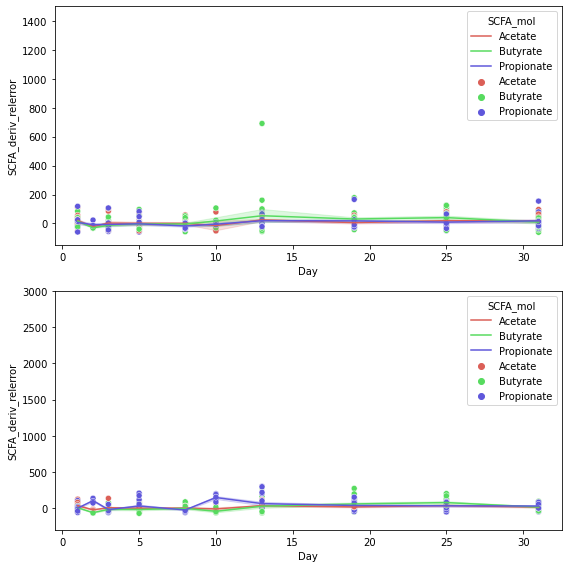

In [41]:
fig, ax = plt.subplots(figsize=(8,8), nrows=2, ncols=1)
feedback=False

# prediction
for idx_j, perturbation in enumerate(['intrapolation','extrapolation']):
    df_tmp = df_test[(df_test.Perturbation==perturbation)&(df_test.Feedback==feedback)]
    df_tmp = df_tmp[df_tmp.Day!=0]
#    _ = sns.boxplot(x='Day', y='RelativeError', hue='SCFA_mol', data=df_tmp, ax=ax[idx_j], palette=sns.color_palette("hls", 3))
    _ = sns.scatterplot(x='Day', y='SCFA_deriv_relerror', hue='SCFA_mol', ci=68, marker='o', data=df_tmp, ax=ax[idx_j], palette=sns.color_palette("hls", 3))
    _ = sns.lineplot(x='Day', y='SCFA_deriv_relerror', hue='SCFA_mol', ci=68, data=df_tmp, ax=ax[idx_j], palette=sns.color_palette("hls", 3))
    if idx_j==0:
        _ = ax[idx_j].set_ylim([-150,1500])
    else:
        _ = ax[idx_j].set_ylim([-300,3000])
#     _ = ax[idx_j].set_title(perturbation+', test')
#     _ = ax[idx_j].plot([-1,9],[-50,-50], 'k--')
#     _ = ax[idx_j].plot([-1,9],[50,50], 'k--')
plt.tight_layout()

# Use non-feedback model

## SCFA deriv error

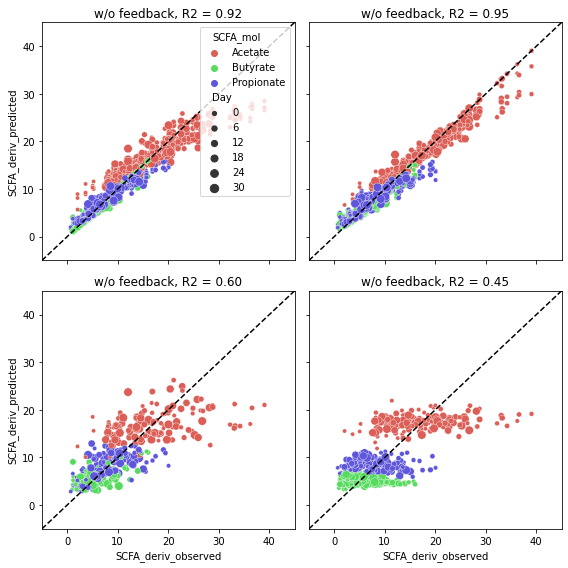

In [51]:
fig, ax = plt.subplots(figsize=(8,8), nrows=2, ncols=2, sharex=True, sharey=True)

feedback=False
if feedback:
    df = pd.read_csv('intrapolation/training_error_intrapolation_w_feedback.csv')
else:
    df = pd.read_csv('intrapolation/training_error_intrapolation_no_feedback.csv')
_ = sns.scatterplot(x='SCFA_deriv_observed',y='SCFA_deriv_predicted', hue='SCFA_mol', size='Day', palette=sns.color_palette("hls", 3), data=df, ax=ax[0,0])
_ = ax[0,0].plot([-5,45],[-5,45],'k--')
_ = ax[0,0].set_xlim([-5,45])
_ = ax[0,0].set_ylim([-5,45])
if feedback:
    _ = ax[0,0].set_title('w/ feedback, R2 = %2.2f'%(r2_score(df.SCFA_deriv_observed, df.SCFA_deriv_predicted)))
else:
    _ = ax[0,0].set_title('w/o feedback, R2 = %2.2f'%(r2_score(df.SCFA_deriv_observed, df.SCFA_deriv_predicted)))

if feedback:
    df = pd.read_csv('extrapolation/training_error_extrapolation_w_feedback.csv')
else:
    df = pd.read_csv('extrapolation/training_error_extrapolation_no_feedback.csv')
_ = sns.scatterplot(x='SCFA_deriv_observed',y='SCFA_deriv_predicted', hue='SCFA_mol', size='Day', palette=sns.color_palette("hls", 3), data=df, ax=ax[0,1])
_ = ax[0,1].plot([-5,45],[-5,45],'k--')
_ = ax[0,1].set_xlim([-5,45])
_ = ax[0,1].set_ylim([-5,45])
if feedback:
    _ = ax[0,1].set_title('w/ feedback, R2 = %2.2f'%(r2_score(df.SCFA_deriv_observed, df.SCFA_deriv_predicted)))
else:
    _ = ax[0,1].set_title('w/o feedback, R2 = %2.2f'%(r2_score(df.SCFA_deriv_observed, df.SCFA_deriv_predicted)))
ax[0,1].legend().remove()

for k,perturbation in enumerate(['intrapolation','extrapolation']):
    df_test_perturb = df_test[(df_test.Perturbation==perturbation) & (df_test.Feedback==feedback)]
    _ = sns.scatterplot(x='SCFA_deriv_observed',y='SCFA_deriv_predicted', hue='SCFA_mol', size='Day', palette=sns.color_palette("hls", 3), data=df_test_perturb, ax=ax[1,k])
    _ = ax[1,k].plot([-5,45],[-5,45],'k--')
    _ = ax[1,k].set_xlim([-5,45])
    _ = ax[1,k].set_ylim([-5,45])
    if feedback:
        _ = ax[1,k].set_title('w/ feedback, R2 = %2.2f'%(r2_score(df_test_perturb.SCFA_deriv_observed, df_test_perturb.SCFA_deriv_predicted)))
    else:
        _ = ax[1,k].set_title('w/o feedback, R2 = %2.2f'%(r2_score(df_test_perturb.SCFA_deriv_observed, df_test_perturb.SCFA_deriv_predicted)))
    ax[1,k].legend().remove()
            
plt.tight_layout()

plt.rcParams['svg.fonttype'] = 'none'
fig.savefig("scfa_deriv_error_no_feedback.svg", format="svg")